In [1]:
import convolution.kernel
import convolution.matrix
from noise import guassian_noise

from signals import rectangle
from domain import equispaced_points
from deconvolution.varpro import variable_projection


import matplotlib.pyplot as plt

from scipy.sparse import spdiags


import numpy as np

Grid of equally spaced points.

In [2]:
t = equispaced_points(512)

Construct latent signal.

In [3]:
latent_signal = rectangle(t)

Construct one gaussian kernel. 

In [4]:
k1_true = convolution.kernel.Gaussian(
    domain=t, 
    standard_deviation=30
)

Construct the convolution operator using a mixture of gaussian kernels. 

In [5]:
K_true = convolution.matrix.Operator(
    kernel=k1_true, 
    structure=convolution.matrix.toeplitz
)

Convolute the latent signal with the convolution operator. 

In [6]:
convoluted_signal = K_true.image @ latent_signal

Set percentage of noise to add to the convoluted signal. 

In [7]:
percentage = 0.02

Construct gaussian noise. 

In [8]:
noise = guassian_noise(percentage, convoluted_signal)

Add the noise to the convoluted signal. 

In [9]:
data = convoluted_signal + noise

Construct the initial guess of the kernel mixture. 

In [10]:
k1 = convolution.kernel.Gaussian(
    domain=t, 
    standard_deviation=60
)
K_guess = convolution.matrix.Operator(
    kernel=k1, 
    structure=convolution.matrix.toeplitz
)

Define regulation matrices. 

The identity matrix. 

In [11]:
def L(x): 
    return np.identity(x.size)

Total variation.

In [12]:
def total_variation(x): 
    BETA = 1e-16
    D = forward_difference_matrix(x)
    return np.diag((1/(((D @ x)**2 + BETA**2)**(1/4)))) @ D

def forward_difference_matrix(data): 
    return spdiags([-np.ones_like(data), np.ones_like(data)], [0, 1], data.size, data.size).toarray()

Define the an approximation to the jacobian matrix. 

In [13]:
def rjf_jacobian(K, x): 
    return np.transpose(np.array(K.partial_derivatives) @ x)

Set the regularization parameter. 

In [14]:
regularization_parameter = 1e-1

Run the variable projection method using the initial guess, `rjf_jacobian`, and regulation using total variation. Also print summary. 

In [15]:
K, x, iterations, change, history = variable_projection(
    data, 
    K_guess, 
    rjf_jacobian,
    regularization_parameter=regularization_parameter, 
    regularization_matrix=total_variation, 
    maximum_iterations=1000,
    signal_guess=None,
    change=1e-16
)
MSE_kernel_guess = np.linalg.norm(K_true.kernel.image - K_guess.kernel.image)**2 / data.size 
MSE_kernel_result = np.linalg.norm(K_true.kernel.image - K.kernel.image)**2 / data.size 
MSE_signal_data = np.linalg.norm(latent_signal - data)**2 / data.size 
MSE_signal_result = np.linalg.norm(latent_signal - x)**2 / data.size 
max_kernel_guess_error = np.linalg.norm(K_true.kernel.image - K_guess.kernel.image, np.inf)
max_kernel_result_error = np.linalg.norm(K_true.kernel.image - K.kernel.image, np.inf)
max_signal_data_error = np.linalg.norm(latent_signal - data, np.inf)
max_signal_result_error = np.linalg.norm(latent_signal - x, np.inf)
print(f'AFTER {iterations} iterations\n\n')
print(f'STOPED when MSE of change in kernel estimate is {change:1.3e}\n\n')
print(f'Regulization parameter: {regularization_parameter}\n\n')
print(f'Variables (TRUE): {K_true.kernel.variables}')
print(f'Variables (GUESS): {K_guess.kernel.variables}')
print(f'Variables (RESULT): {K.kernel.variables}\n\n')
print(f'Mean Squared Error of Kernel (TRUE & GUESS): {MSE_kernel_guess:1.3e}')
print(f'Mean Squared Error of Kernel (TRUE & RESULT): {MSE_kernel_result:1.3e}\n')
print(f'Max error of Kernel (TRUE & GUESS): {max_kernel_guess_error:1.3e}')
print(f'Max error of Kernel (TRUE & RESULT): {max_kernel_result_error:1.3e}\n\n')
print(f'Mean Squared Error of Signal (TRUE & DATA): {MSE_signal_data:1.3e}')
print(f'Mean Squared Error of Signal (TRUE & RESULT): {MSE_signal_result:1.3e}\n')
print(f'Max error of Signal (TRUE & DATA): {max_signal_data_error:1.3e}')
print(f'Max error of Signal (TRUE & RESULT): {max_signal_result_error:1.3e}')


AFTER 94 iterations


STOPED when MSE of change in kernel estimate is 8.856e-17


Regulization parameter: 0.1


Variables (TRUE): [30]
Variables (GUESS): [60]
Variables (RESULT): [29.72582383608424]


Mean Squared Error of Kernel (TRUE & GUESS): 4.309e-06
Mean Squared Error of Kernel (TRUE & RESULT): 1.164e-09

Max error of Kernel (TRUE & GUESS): 6.649e-03
Max error of Kernel (TRUE & RESULT): 1.227e-04


Mean Squared Error of Signal (TRUE & DATA): 2.733e-02
Mean Squared Error of Signal (TRUE & RESULT): 1.885e-03

Max error of Signal (TRUE & DATA): 4.899e-01
Max error of Signal (TRUE & RESULT): 4.383e-01


Visualize the results.

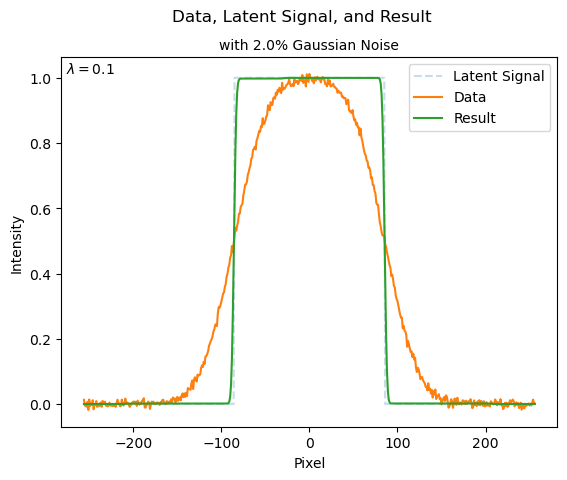

In [16]:
fig, ax = plt.subplots()
plt.suptitle('Data, Latent Signal, and Result')
plt.title(f'with {percentage * 100:}% Gaussian Noise', fontsize=10)
ax.plot(t, latent_signal, '--', label='Latent Signal', alpha=0.25)
ax.plot(t, data, label='Data')
ax.plot(t, x, label='Result')
ax.legend()
ax.text(.01, .99, r'$\lambda = $' + f'{regularization_parameter}', ha='left', va='top', transform=ax.transAxes)
plt.xlabel('Pixel')
plt.ylabel('Intensity');

Visualize the kernel result.

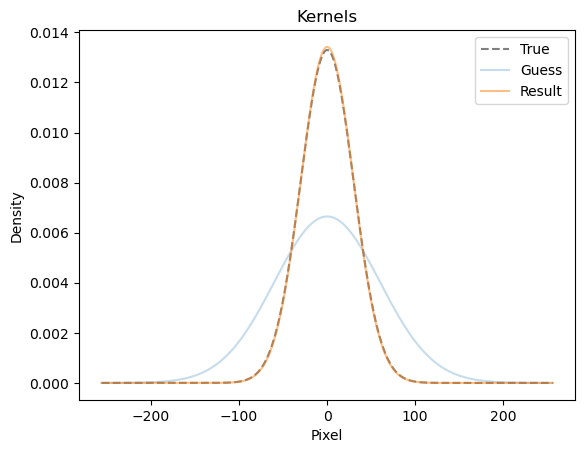

In [17]:
plt.title("Kernels")
plt.plot(t, K_true.kernel.image, 'k--', label='True', alpha=0.5)
plt.plot(t, K_guess.kernel.image, label="Guess", alpha=0.25)
plt.plot(t, K.kernel.image, label='Result', alpha=0.5)
plt.legend()
plt.xlabel('Pixel')
plt.ylabel('Density');

Get errors per iteration for convergence results. 

Error of kernel.

In [18]:
err_kernel = [np.linalg.norm(K.kernel.image - K_true.kernel.image) for K, _, _, _ in history]

Error of signal. 

In [19]:
err_x = [np.linalg.norm(latent_signal - x) for _, x, _, _ in history]

The change in the stopping condition per iteration.

In [20]:
mean_squared_err = [err for _, _, _, err in history]

Get the objective function. 

In [21]:
functional_per_iteration = [np.linalg.norm(K.image @ x - data)**2 + regularization_parameter**2 * np.linalg.norm(L(x) * x)**2 for K, x, _, _ in history ]


In [22]:
best_fit_per_iteration = [np.linalg.norm(K.image @ x - data)**2 for K, x, _, _ in history ]

In [23]:
regularization_parameter_per_iteration = [ regularization_parameter**2 * np.linalg.norm(L(x) * x)**2 for K, x, _, _ in history ]

In [24]:
m = min(best_fit_per_iteration)

Visualize convergence of kernel result.

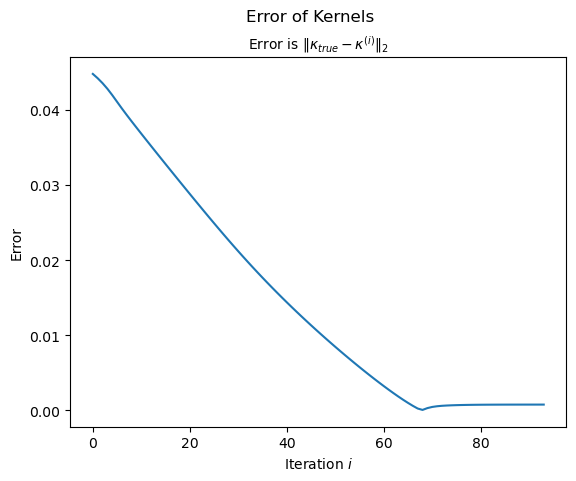

In [25]:
plt.suptitle('Error of Kernels')
plt.title(r'Error is $\|\kappa_{true} - \kappa^{(i)}\|_2$', fontsize=10)
plt.plot(err_kernel)
plt.xlabel(r'Iteration $i$')
plt.ylabel('Error');

Visualize convergence of signal.

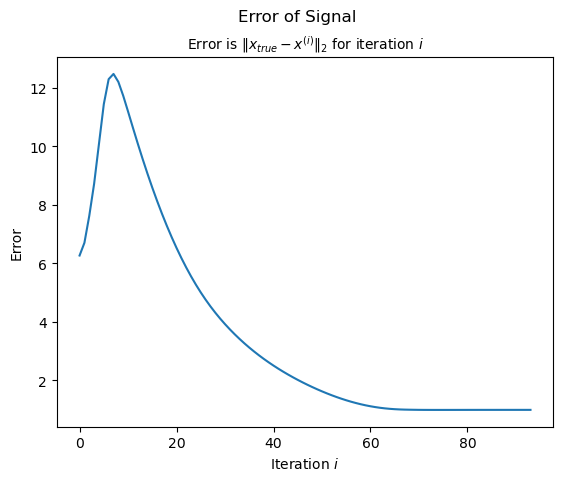

In [26]:
plt.suptitle('Error of Signal')
plt.title(r'Error is $\|x_{true} - x^{(i)} \|_2$ for iteration $i$', fontsize=10)
plt.plot(err_x)
plt.xlabel(r'Iteration $i$')
plt.ylabel('Error');

Visualize the stopping condition per iteration. 

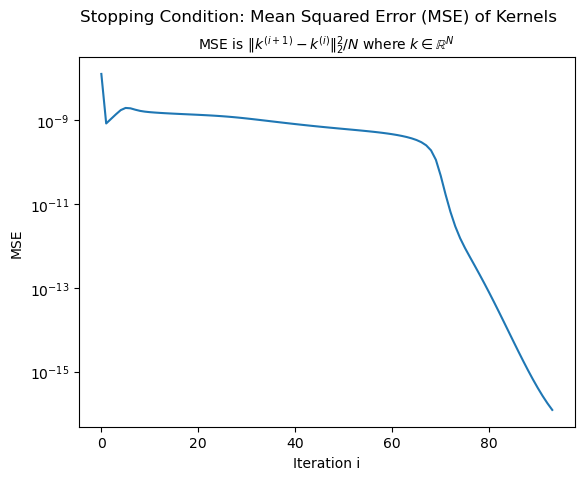

In [27]:
plt.suptitle('Stopping Condition: Mean Squared Error (MSE) of Kernels')
plt.title(r'MSE is $\|k^{(i+1)} - k^{(i)} \|_2^2 / N$ where $k\in\mathbb{R}^N$', fontsize=10 )
plt.semilogy(mean_squared_err)
plt.ylabel('MSE')
plt.xlabel(r'Iteration i');

Visualize the objective function per iteration.

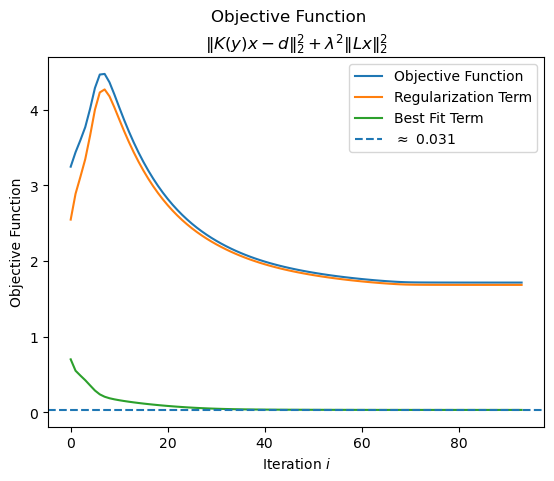

In [28]:
plt.suptitle('Objective Function')
plt.title(r'$\|K(y) x - d\|_2^2 + \lambda^2 \|Lx\|_2^2$')
plt.plot(functional_per_iteration, label='Objective Function')
plt.plot(regularization_parameter_per_iteration, label='Regularization Term')
plt.plot(best_fit_per_iteration, label='Best Fit Term')
plt.axhline(m, linestyle='dashed', label=r'$\approx$ ' + f'{m:.2}')
plt.legend()
plt.xlabel(r'Iteration $i$')
plt.ylabel('Objective Function'); 

Now we try the variable projection method using a different regularization matrix. In this case we use the identity matrix. 

In [29]:
K, x, iterations, change, history = variable_projection(
    data, 
    K_guess, 
    rjf_jacobian,
    regularization_parameter=regularization_parameter, 
    regularization_matrix=L, 
    maximum_iterations=50,
    signal_guess=None,
    change=1e-16
)
MSE_kernel_guess = np.linalg.norm(K_true.kernel.image - K_guess.kernel.image)**2 / data.size 
MSE_kernel_result = np.linalg.norm(K_true.kernel.image - K.kernel.image)**2 / data.size 
MSE_signal_data = np.linalg.norm(latent_signal - data)**2 / data.size 
MSE_signal_result = np.linalg.norm(latent_signal - x)**2 / data.size 
max_kernel_guess_error = np.linalg.norm(K_true.kernel.image - K_guess.kernel.image, np.inf)
max_kernel_result_error = np.linalg.norm(K_true.kernel.image - K.kernel.image, np.inf)
max_signal_data_error = np.linalg.norm(latent_signal - data, np.inf)
max_signal_result_error = np.linalg.norm(latent_signal - x, np.inf)
print(f'AFTER {iterations} iterations\n\n')
print(f'STOPED when MSE of change in kernel estimate is {change:1.3e}\n\n')
print(f'Regulization parameter: {regularization_parameter}\n\n')
print(f'Variables (TRUE): {K_true.kernel.variables}')
print(f'Variables (GUESS): {K_guess.kernel.variables}')
print(f'Variables (RESULT): {K.kernel.variables}\n\n')
print(f'Mean Squared Error of Kernel (TRUE & GUESS): {MSE_kernel_guess:1.3e}')
print(f'Mean Squared Error of Kernel (TRUE & RESULT): {MSE_kernel_result:1.3e}\n')
print(f'Max error of Kernel (TRUE & GUESS): {max_kernel_guess_error:1.3e}')
print(f'Max error of Kernel (TRUE & RESULT): {max_kernel_result_error:1.3e}\n\n')
print(f'Mean Squared Error of Signal (TRUE & DATA): {MSE_signal_data:1.3e}')
print(f'Mean Squared Error of Signal (TRUE & RESULT): {MSE_signal_result:1.3e}\n')
print(f'Max error of Signal (TRUE & DATA): {max_signal_data_error:1.3e}')
print(f'Max error of Signal (TRUE & RESULT): {max_signal_result_error:1.3e}')


AFTER 50 iterations


STOPED when MSE of change in kernel estimate is 4.206e-07


Regulization parameter: 0.1


Variables (TRUE): [30]
Variables (GUESS): [60]
Variables (RESULT): [0.5350214076833009]


Mean Squared Error of Kernel (TRUE & GUESS): 4.309e-06
Mean Squared Error of Kernel (TRUE & RESULT): 1.100e-03

Max error of Kernel (TRUE & GUESS): 6.649e-03
Max error of Kernel (TRUE & RESULT): 7.272e-01


Mean Squared Error of Signal (TRUE & DATA): 2.733e-02
Mean Squared Error of Signal (TRUE & RESULT): 2.779e-02

Max error of Signal (TRUE & DATA): 4.899e-01
Max error of Signal (TRUE & RESULT): 4.929e-01


Visualize the result.

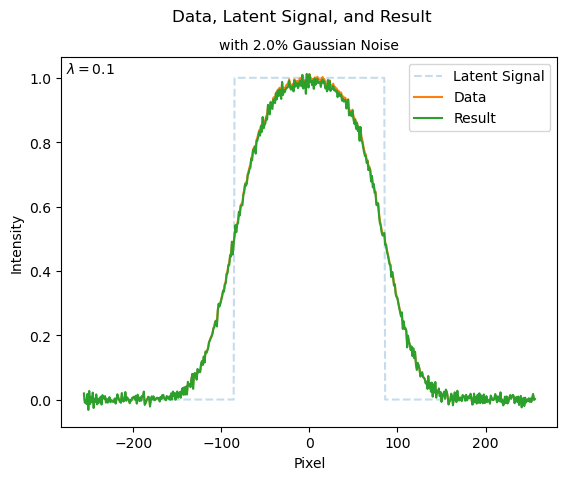

In [30]:
fig, ax = plt.subplots()
plt.suptitle('Data, Latent Signal, and Result')
plt.title(f'with {percentage * 100:}% Gaussian Noise', fontsize=10)
ax.plot(t, latent_signal, '--', label='Latent Signal', alpha=0.25)
ax.plot(t, data, label='Data')
ax.plot(t, x, label='Result')
ax.legend()
ax.text(.01, .99, r'$\lambda = $' + f'{regularization_parameter}', ha='left', va='top', transform=ax.transAxes)
plt.xlabel('Pixel')
plt.ylabel('Intensity');

The result does not approximate the latent signal any better than the provided data. 

Visualize resulting kernel mixture. 

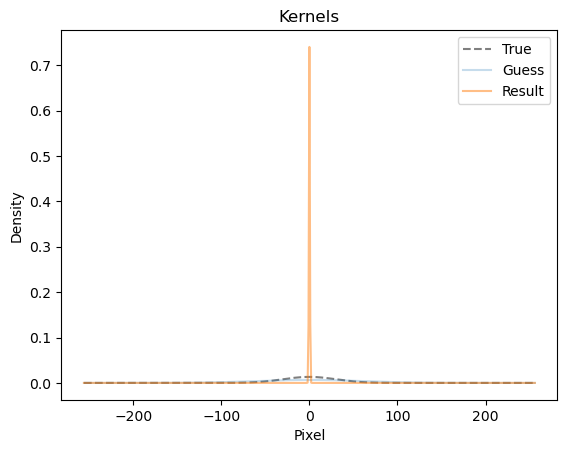

In [31]:
plt.title("Kernels")
plt.plot(t, K_true.kernel.image, 'k--', label='True', alpha=0.5)
plt.plot(t, K_guess.kernel.image, label="Guess", alpha=0.25)
plt.plot(t, K.kernel.image, label='Result', alpha=0.5)
plt.legend()
plt.xlabel('Pixel')
plt.ylabel('Density');

It appears that the variable projection method has returned the dirac delta function. 

In [32]:
functional_per_iteration = [np.linalg.norm(K.image @ x - data)**2 + regularization_parameter**2 * np.linalg.norm(L(x) * x)**2 for K, x, _, _ in history ]

In [33]:
best_fit_per_iteration = [np.linalg.norm(K.image @ x - data)**2 for K, x, _, _ in history ]

In [34]:
regularization_parameter_per_iteration = [ regularization_parameter**2 * np.linalg.norm(L(x) * x)**2 for K, x, _, _ in history ]

In [35]:
m = min(best_fit_per_iteration)


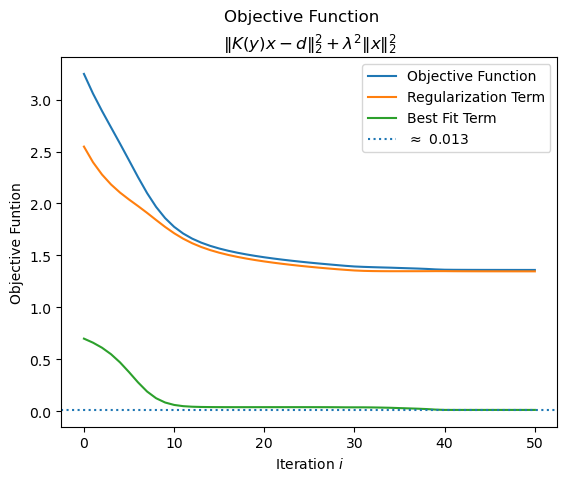

In [36]:
plt.suptitle('Objective Function')
plt.title(r'$\|K(y) x - d\|_2^2 + \lambda^2 \|x\|_2^2$')
plt.plot(functional_per_iteration, label='Objective Function')
plt.plot(regularization_parameter_per_iteration, label='Regularization Term')
plt.plot(best_fit_per_iteration, label='Best Fit Term')
plt.axhline(m, linestyle='dotted', label=r'$\approx$ ' + f'{m:.2}')
plt.legend()
plt.xlabel(r'Iteration $i$')
plt.ylabel('Objective Funtion'); 

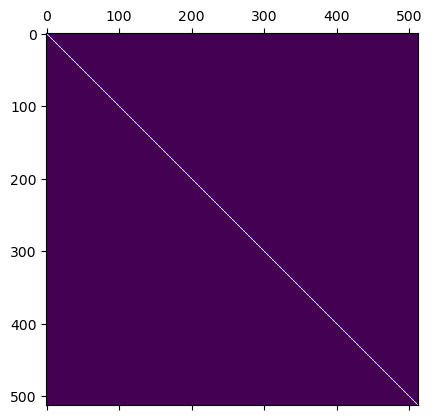

In [37]:
plt.matshow(K.image)

In [38]:
from scipy.linalg import pinv

def G(sigma): 

    g = convolution.kernel.Gaussian(
        domain=t, 
        standard_deviation=sigma
    )
    G = convolution.matrix.Operator(
        kernel=g, 
        structure=convolution.matrix.toeplitz
    )
    return G.image

def reduced_functional(sigmas, reg_parameter, reg_matrix, data): 
    result = []
    I = reg_matrix(latent_signal)
    for sigma in sigmas:
        GL = np.block([[G(sigma)], [reg_parameter * I]])
        D = np.block([data, np.zeros_like(data)]) # data: d tilde (not derivative operator)
        x = pinv(GL) @ D
        result.append(
            np.linalg.norm(GL @ x - D)
        )
    return result

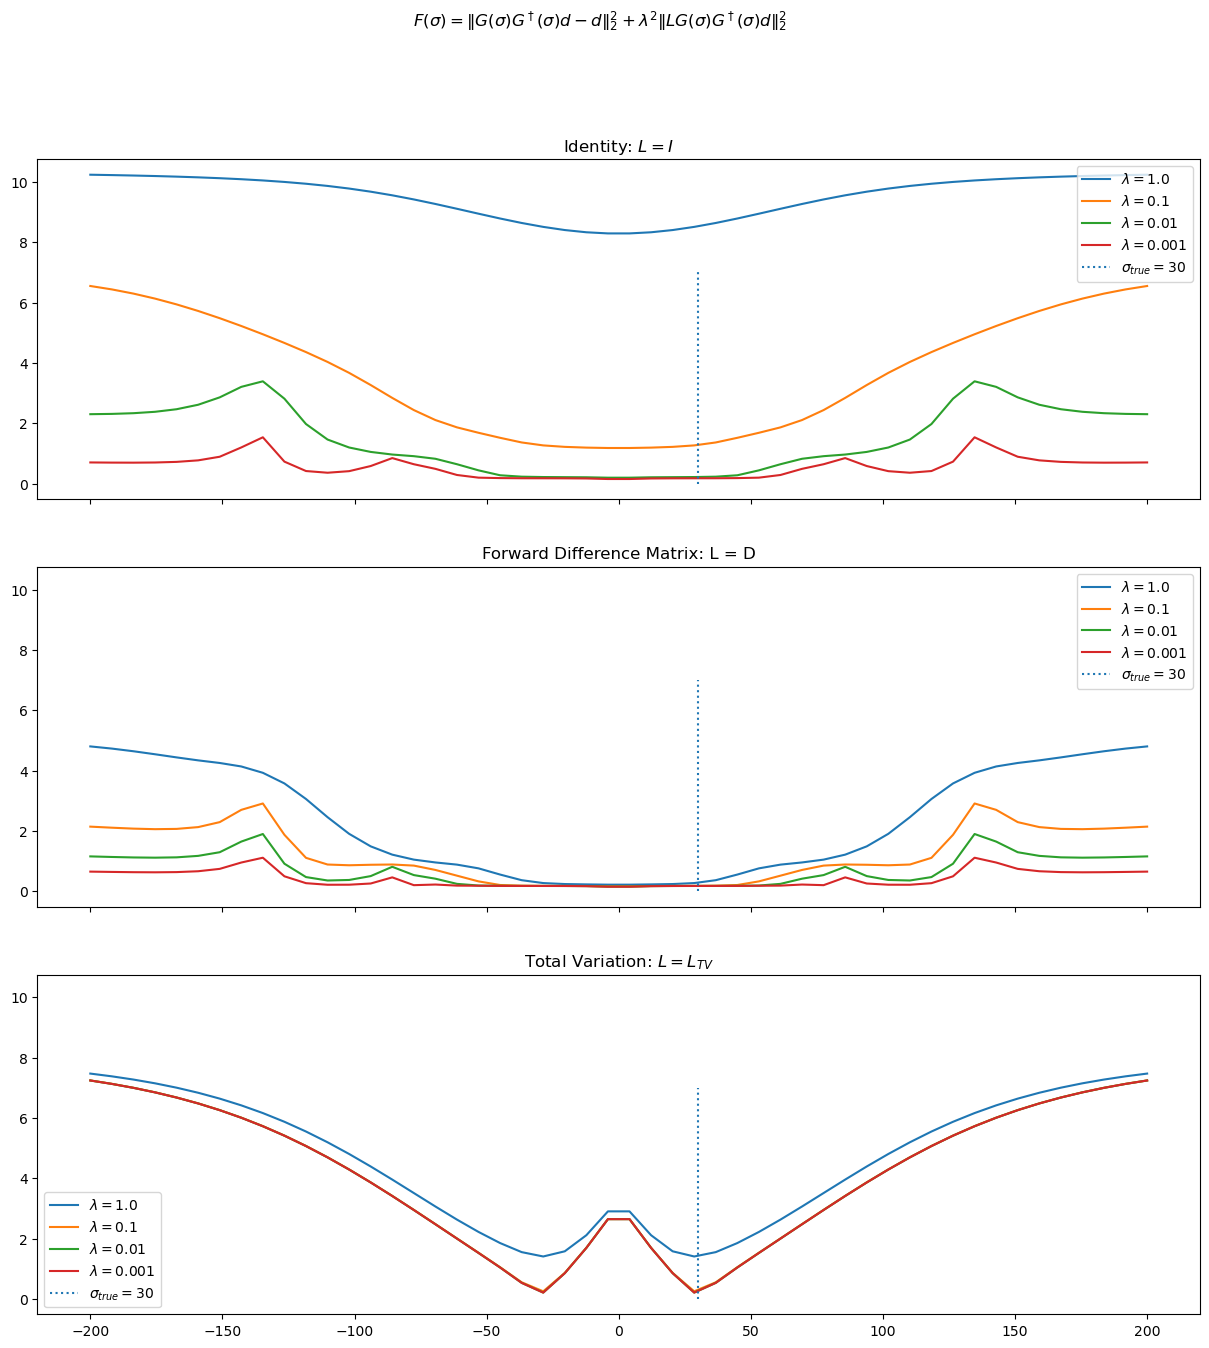

In [87]:
sigmas = np.linspace(-200,200)
reg_parameter = 1e0

fig, axs = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(15, 15))
fig.suptitle(r'$F(\sigma) = \|G(\sigma)G^\dagger(\sigma)d - d \|_2^2 + \lambda^2 \|L G(\sigma)G^\dagger(\sigma)d\|_2^2$')

ax = axs[0]
I = L
for reg_parameter in [1e0, 1e-1, 1e-2, 1e-3]:
    F0 = reduced_functional(sigmas, reg_parameter, I, data)
    ax.plot(sigmas, F0, label=r'$\lambda=$' + f'{reg_parameter}')
ax.title.set_text('Identity: ' + r'$L = I$')
ax.vlines(30, 0, 7, linestyles=':', label=r'$\sigma_{true}=$' + f'30')
ax.legend(loc='upper right')

ax = axs[1]
for reg_parameter in [1e0, 1e-1, 1e-2, 1e-3]:
    F0 = reduced_functional(sigmas, reg_parameter, forward_difference_matrix, data)
    ax.plot(sigmas, F0, label=r'$\lambda=$' + f'{reg_parameter}')
ax.title.set_text('Forward Difference Matrix: ' + r'L = D')
ax.vlines(30, 0, 7, linestyles=':', label=r'$\sigma_{true}=$' + f'30')
ax.legend()

ax = axs[2]
for reg_parameter in [1e0, 1e-1, 1e-2, 1e-3]:
    F0 = reduced_functional(sigmas, reg_parameter, total_variation, data)
    ax.plot(sigmas, F0, label=r'$\lambda=$' + f'{reg_parameter}')
ax.title.set_text('Total Variation: ' + r'$L = L_{TV}$')
ax.vlines(30, 0, 7, linestyles=':', label=r'$\sigma_{true}=$' + f'30')
ax.legend()


Recall that the true standard deviation is 30. 

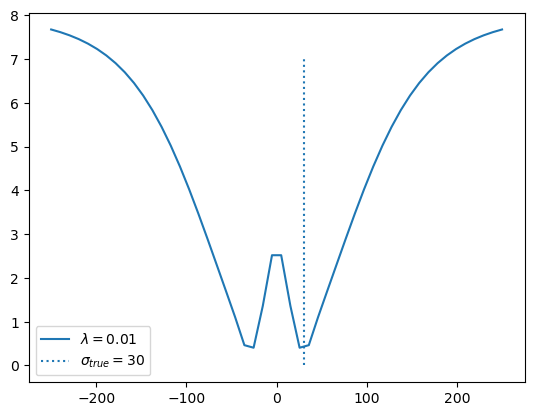

In [40]:
sigmas = np.linspace(-250,250)
reg_parameter = 1e-2
F0 = reduced_functional(sigmas, reg_parameter, total_variation, data)
plt.plot(sigmas, F0, label=r'$\lambda=$' + f'{reg_parameter}')
plt.vlines(30, 0, 7, linestyles=':', label=r'$\sigma_{true}=$' + f'30')
plt.legend()